In [ ]:
%matplotlib inline

# Assignment 4

**DUE: Sunday November 20, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [ ]:
NAME = "Fabrice Kurmann"
STUDENT_ID = "1808546"

## Gesture Recognition
---
**BEFORE YOU START: Change the runtime to GPU. From the "Runtime" dropdown menu in the toolbar above select "change runtime type". Then change :Hardware accelerator" to GPU.**


American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabet are shown below. In this question, you will focus on classifying these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters, we want to detect which letter is being represented.


<img src = 'https://drive.google.com/uc?id=1nRxq6yqDkmumUuePXfDx_5YgGl9vKXcj' width="300">






Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1Z03YaFEvmGW5dapUex99nQF_Vxa2lriJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('asl_1000.zip')
!unzip -q asl_1000.zip

Now that you downloaded the data, you see a directory containing 26 subdirectories that contain the hand gesture images. Notice that the subdirectories are named after the classes. Each of the subdirectories contains 1000 RGB images for its' respective class. Each RGB image has a height and width of $200\times 200$. In Questions 1, 2, and 3, you will use use the tensorflow .image_dataset_from_directory() to create training and validation sets. The following cells implent a small tutorial for visualizing some training examples.

 Coding examples from adapted from: https://www.tensorflow.org/tutorials/load_data/images

### Create a dataset
Define some parameters for the loader:

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

batch_size = 32 # The batch size
img_height = 200 # Image resize height
img_width = 200 # Image resize width
data_dir = "asl_1000/asl_alphabet_train" # Data directory

Use 80% of the images for training and 20% for validation.

In [ ]:
# Create training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26000 files belonging to 26 classes.
Using 20800 files for training.


In [ ]:
# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 26000 files belonging to 26 classes.
Using 5200 files for validation.


Print the class names in the class_names attribute on these datasets. Notice that the class names are inferred from the subdirectory's names.




In [ ]:
class_names = train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Visualize the data


Here are the first 9 images from the training dataset.

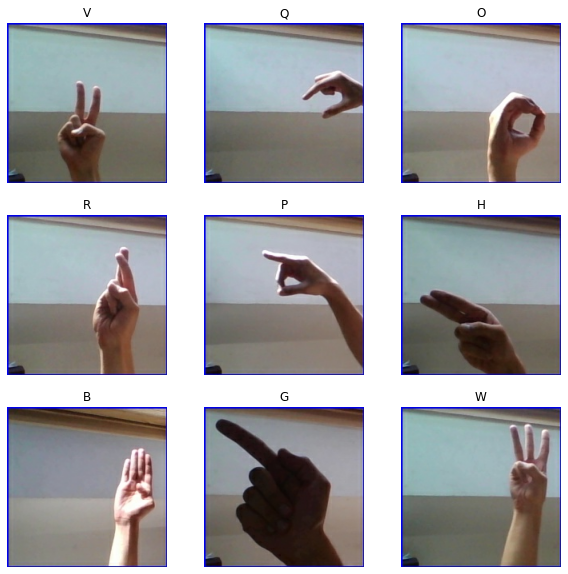

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Here are the first 9 images from the validation dataset.

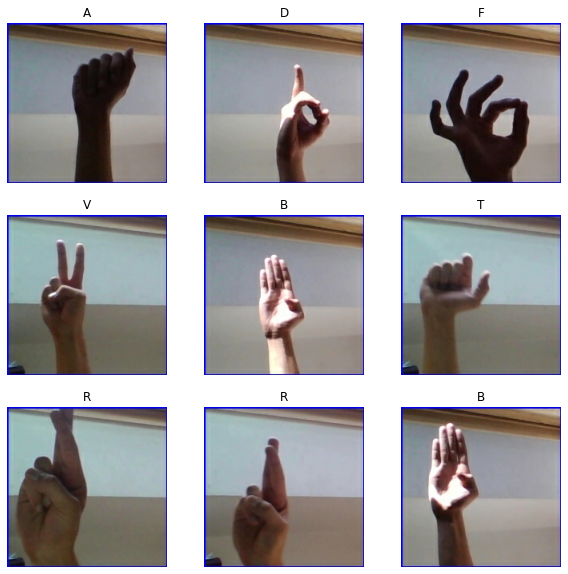

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to model.fit (shown later in this tutorial). Let's retrieve one batch from the training datset and check the outputs.

In [ ]:
for features_batch, labels_batch in train_ds:
  print(features_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


features_batch is a single single batch from the training dataset. It contains $32$ $height=200$ by, $width=200$ by, $channel=3$ images from the training dataset. The size of the last dimension is 3, and contains the RGB values of the pixels. The labels are simply of size (32,). 

##  Question 1 - Fully-Connected Neural Network
---

###Part A) Understanding and Processing the Data (10 points)

Now that you downloaded the data, you should see a folder containing the images in their respective subdirectories. Complete the following steps (you may reuse the code from the tutorial):

1) read in the training and test data.

2) make sure that all of your images are of size $200\times 200$. If not, scale them appropriately.

3) rescale the pixel values of the training and test images from [0,255] to [0,1]. <br> Hint: tf.keras.layers.experimental.preprocessing.Rescaling(1./255) is recommended, see example at https://www.tensorflow.org/tutorials/load_data/images)

4) Ensure that your target values (classes) are stored appropriately. You must have 26 classes for 'A-Z'.

In [ ]:
# Read in training and test data
batch_size = 32 # The batch size
img_height = 200 # Image resize height
img_width = 200 # Image resize width


# Training dataset
data_dir = "asl_1000/asl_alphabet_train" # Data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Create validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Normalize pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`
print(np.min(first_image), np.max(first_image))


Found 26000 files belonging to 26 classes.
Using 20800 files for training.
Found 26000 files belonging to 26 classes.
Using 5200 files for validation.
0.0 1.0


###Part B) Building a Fully-Connected Neural Network (10 points)
Now that the dataset is downloaded, let's see what happens when we try to allocate a fully-connected neural network with a flatten layer, two hidden layers and an output layer to take in the $200 \times 200 \times 3$ images. Recall that our batch size is still 32. Don't spend too much time on this model.

In [ ]:
import tensorflow as tf

# Create the network
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

# Build neural network
def build_model(): 
  model = Sequential() 
  model.add(tf.keras.layers.Flatten()),
  model.add(Dense(units = 1000, input_dim=120000, activation='relu')),
  model.add(Dense(units = 100, activation='relu')),
  model.add(Dense(units = 26, activation='softmax')), 
  return model

model = build_model()

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

# Call fit on the model
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
650/650 [==============================] - 29s 44ms/step - loss: 1171.6462 - accuracy: 0.0396 - val_loss: 3.2584 - val_accuracy: 0.0338
Epoch 2/10
650/650 [==============================] - 29s 45ms/step - loss: 3.2584 - accuracy: 0.0378 - val_loss: 3.2587 - val_accuracy: 0.0338
Epoch 3/10
650/650 [==============================] - 29s 44ms/step - loss: 3.2584 - accuracy: 0.0383 - val_loss: 3.2588 - val_accuracy: 0.0338
Epoch 4/10
650/650 [==============================] - 31s 47ms/step - loss: 3.2584 - accuracy: 0.0386 - val_loss: 3.2589 - val_accuracy: 0.0338
Epoch 5/10
650/650 [==============================] - 32s 50ms/step - loss: 3.2584 - accuracy: 0.0378 - val_loss: 3.2590 - val_accuracy: 0.0338
Epoch 6/10
650/650 [==============================] - 31s 48ms/step - loss: 3.2584 - accuracy: 0.0381 - val_loss: 3.2590 - val_accuracy: 0.0338
Epoch 7/10
650/650 [==============================] - 31s 48ms/step - loss: 3.2584 - accuracy: 0.0379 - val_loss: 3.2591 - val_accura

KeyboardInterrupt: ignored

Assuming the code is correct, did you get any errors upon running the cell? If so, why do you think this error occured? Also, how many parameters does the above model have?

With 200 * 200 * 3 pixels the input layer has a total size of 120,000, this then creates an even larger amount of connections to the subsequent layers since we are working with a fully connected neural network.

This code does not have any runtime errors, however, after multiple changes in setup it has been impossible to achieve a good accuracy result. Validation accuracy hovers around 3 percent, neither improving or dropping after multiple epochs of training, the same can be said for loss, which drops after only the first epoch of training.


##  Question 2 - Convolutional Neural Networks
---
You have seen the shortcomings of using a fully-connected neural network for image recognition tasks. You will now build a convolutional network. For the rest of this assignment, we are not going to give you any starter code. You are welcome to use any code from previous class exercises, section handouts, and lectures. You may reuse your training and validation sets that you created in Question 1. You should also write your own code.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unnecessary for loops). Ensure enough comments are included in the code so that your TA can understand what you are doing. It is your responsibility to show that you understand what you write.

Follow the steps below to show your work.

#### Part A) Building the Network (15 points)
Build a convolutional neural network model that takes the ($200\times 200 \times 3$ RGB) image as input, and predicts the letter.

Explain your choice of the architecture: how many layers did you choose? What types of layers did you use? Did you use dropout or normalization layers? What about other decisions like activation functions, kernel size, stride, and padding? Lastly, how many parameters does your model have?

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

encoder_input = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)
model0 = keras.Model(encoder_input, encoder_output)
model0.summary()

model0.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

(32, 200, 200, 3)
(32,)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 66, 66, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 26)                3407898   
                                     

For this first convolutional neural network, I included an input layer followed by 2 convolutional layers, both without padding, a stride of 1, filter size of 3*3, a filter count of 32, and relu activation. Between my convolutional layers, I have a max pooling layer with a dimension of 3. Then, I flatten the output before feeding it into a dense layer with 26 classifiers for 26 letters of the alphabet, using softmax activation.

This model has 3418042 parameters in total, the majority of which are still in the final dense layer.

#### Part B) Training the Network (15 points)
Write code that trains your CNN given the training data (check the dataset tutorial to see how to use .fit with your custom dataset). Your training code should make it easy to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function and optimizer.

Plot the training curve as well.

Epoch 1/10
650/650 [==============================] - 32s 38ms/step - loss: 23.5282 - accuracy: 0.7317 - val_loss: 0.2853 - val_accuracy: 0.9102
Epoch 2/10
650/650 [==============================] - 29s 45ms/step - loss: 0.1027 - accuracy: 0.9694 - val_loss: 0.4926 - val_accuracy: 0.8860
Epoch 3/10
650/650 [==============================] - 30s 45ms/step - loss: 0.0883 - accuracy: 0.9774 - val_loss: 0.3792 - val_accuracy: 0.9337
Epoch 4/10
650/650 [==============================] - 26s 39ms/step - loss: 0.1016 - accuracy: 0.9770 - val_loss: 0.4902 - val_accuracy: 0.9229
Epoch 5/10
650/650 [==============================] - 27s 41ms/step - loss: 0.0771 - accuracy: 0.9842 - val_loss: 0.5313 - val_accuracy: 0.9223
Epoch 6/10
650/650 [==============================] - 27s 41ms/step - loss: 0.0639 - accuracy: 0.9864 - val_loss: 0.5582 - val_accuracy: 0.9000
Epoch 7/10
650/650 [==============================] - 25s 38ms/step - loss: 0.0861 - accuracy: 0.9816 - val_loss: 0.4106 - val_accuracy

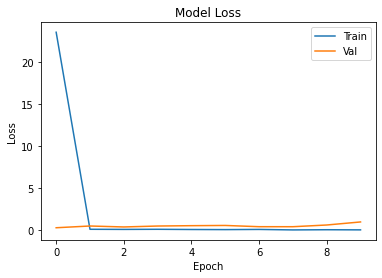

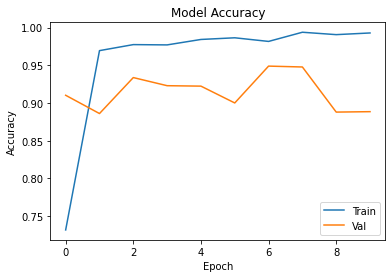

In [ ]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

hist = model0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

I started by using the adam optimizer with a standard learning rate and sparse categorical crossentropy as my loss function.

From the training curve it appears that loss and accuracy do not improve drastically over multiple epochs. I'm unsure whether this is as a result of my small batch size allowing a large amount of improvement in the 1st epoch already, or the model not being able to improve due to the way I have configured it, I will investigate this below.

#### Part C) Hyperparameter Search (15 points)

1. List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to the model architecture.

2. Tune the hyperparameters you listed previously, trying as many values as you need to until you feel satisfied that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

3. Choose the best model out of all the ones that you have trained. Justify your choice.

4. Report the test accuracy of your best model. You should only do this step once.







For this model, I tried to reduce the number of parameters being trained in the dense layer to more heavily leverage the convolutional layers. I added another pooling layer and increased my stride 2, to help decrease the size of the convolutional outputs.

These changes decrease the parameter count to 30970, about 1% of the prior model's. Accuracy when training this model grows far more gradually than the first, unsurprising given the far lower complexity, however, after my 10 epochs, the accuracy is able to catch up to and surpass the prior model's.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 99, 99, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 33, 33, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 800)               0   

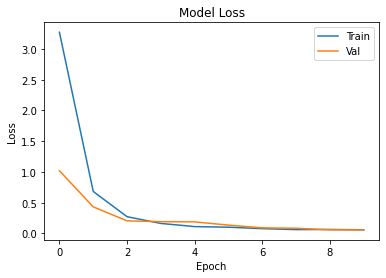

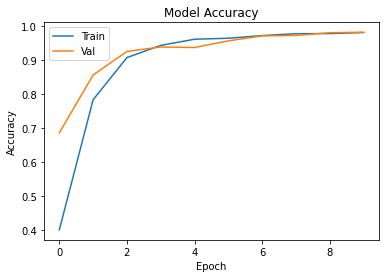

In [ ]:
# Setting 1
encoder_input = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2)(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2)(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Flatten()(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)
# = layers.GlobalMaxPooling2D()


model1 = keras.Model(encoder_input, encoder_output)
model1.summary()

model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

The above updates have certainly improved the shape of my training curve, but I am unable to reach a clear maximum in 10 epochs. I am updating to use the adagrad optimizer here to see if it is able to train the model more quickly than adam, to perhaps allow me to reach an even better accuracy in the same number of epochs.

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 66, 66, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_4 (Dense)             (None, 26)                3407898   
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


650/650 [==============================] - 26s 39ms/step - loss: 22.1058 - accuracy: 0.8056 - val_loss: 0.1196 - val_accuracy: 0.9702
Epoch 2/10
650/650 [==============================] - 27s 42ms/step - loss: 0.0359 - accuracy: 0.9954 - val_loss: 0.0651 - val_accuracy: 0.9840
Epoch 3/10
650/650 [==============================] - 29s 44ms/step - loss: 0.0140 - accuracy: 0.9997 - val_loss: 0.0502 - val_accuracy: 0.9869
Epoch 4/10
650/650 [==============================] - 25s 38ms/step - loss: 0.0086 - accuracy: 0.9999 - val_loss: 0.0437 - val_accuracy: 0.9896
Epoch 5/10
650/650 [==============================] - 26s 40ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9896
Epoch 6/10
650/650 [==============================] - 25s 39ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0364 - val_accuracy: 0.9902
Epoch 7/10
650/650 [==============================] - 27s 42ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9906
Ep

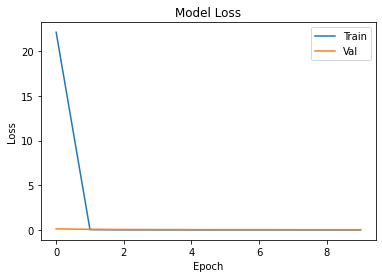

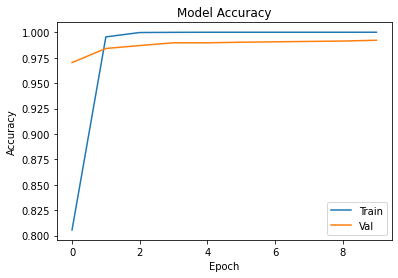

In [ ]:
from tensorflow.keras.optimizers import Adagrad

# Setting 2
encoder_input = keras.Input(shape=(200, 200, 3), name="img")
x = layers.Conv2D(32, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)

model2 = keras.Model(encoder_input, encoder_output, name="encoder")
model2.summary()

model2.compile(
  optimizer=Adagrad(lr = 0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

I will try and add another convolution layer to try and extract features more effectivly and reduce the burden on the dense layer even further.

The number of trainable parameters are now 38650. 

I also halve the batch size and epoch count here to see if there is a benefit to decraseing batch size, causing more training iterations per epoch at a tradeoff of less epochs.

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 100, 32)      416       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 32)          4128

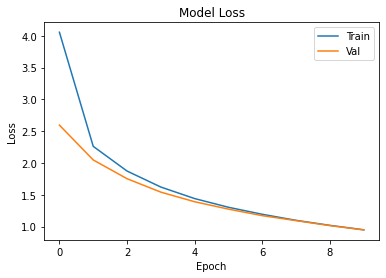

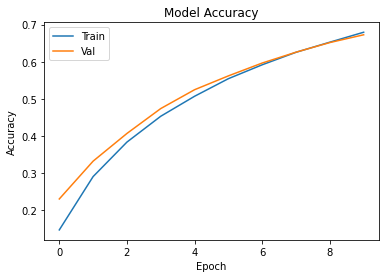

In [ ]:
# Setting 3
encoder_input = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(32, 2, activation="relu", strides=2)(encoder_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 2, activation="relu", strides=2)(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 2, activation="relu", strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)

model3 = keras.Model(encoder_input, encoder_output, name="encoder")
model3.summary()

model3.compile(
  optimizer=Adagrad(lr = 0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model3.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=16,
  epochs=20
)

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

The above model seems to go too far in terms of convolution, with the resulting accuracy dropping off considerable. It is unlikely that even with more epochs it will reach the high 90 percent accuracy of the other configurations.

Since my 1st altered model with more convolution was successful in beating the original's validation accuracy with far fewer parameters, I decided try and apply this configuration paired with the adagrad optimizer.

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 99, 99, 16)        448       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 33, 33, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 16)        2320      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 16)         0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 400)               0   

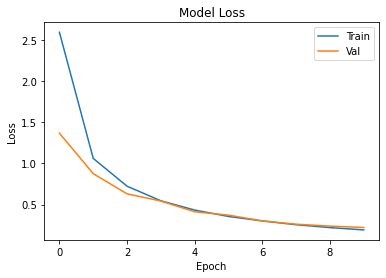

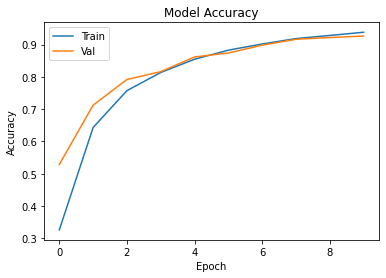

In [ ]:
# Setting 4
encoder_input = keras.Input(shape=(200, 200, 3))
x = layers.Conv2D(64, 3, activation="relu", strides=2)(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2)(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Flatten()(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)

model4 = keras.Model(encoder_input, encoder_output, name="encoder")
model4.summary()

model4.compile(
  optimizer=Adagrad(lr = 0.01),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

**2C Discussion**

I focused on tuning the model in terms of adding convultion layers and pooling layers while also experimenting with stride increases. I wanted to use my convolutional layers to help simplify the job for my dense layer by decrasing its input size, which is why I avoided using padding and also made use of pooling. Then, in terms of optimizer hyperparemeters, I altered both the choice of optimizer from adam to the better performing adagrad and the learning rate, which ended up having a surprisingly small effect in my testing. Finally, I experimented with decreasing batch size and epoch count to test the limits of mini batch size correlating to efficiency improvements.

Initially My best model above was the second alteration, where I still had a rather narrow convultion layer and therefore a lot of trainable parameters in my dense layer, however, was using the adagrad optimizer to give me a validation **accuracy of 99.21 percent after 10 epochs**. 

That said, this model was followed closely in terms of accuracy by the 4th and first models I trained, which added a pooling layer and increased stride to make for only about 1% of the total trainable parameters. Considering the efficiency and simplicity improvements this yields, I think the less than 0.5% loss im validation accuracy for the same number of epochs with equal batch size makes these models compelling as well. I ended up making one more alteration to the 4th model: altering the kernel size to be larger, to potentially catch larger features in the image as well. **This modification brough up the 4th model's accuracy to 99.63%**, the best I achieved, with a network with far fewer trainable parameters than its predecessor. To back up this hypothesis, decrasing kernel size had a negative effect of accuracy.

I also never experienced overfitting with the number of epochs I was running (more epochs would not have been practical due to time anyways) so I did not use any dropout layers.

I kept the same sparse categorical crossentropy loss function since it is the recommendation for models with nonbinary outputs as this one is and non one hot encoded inputs.

## Question 3 - Transfer Learning
---
For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer Learning. In this assignment, we will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which get utilized by the fully-connected layers for correct classification.


Keras even has pretrained models built in for this purpose. 

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. We'll use VGG16, which was trained to recognize 1000 objects in ImageNet. What we're doing here for our classifier may be akin to killing a fly with a shotgun, but the same process can be used to recognize objects the original network couldn't (i.e., you could use this technique to train your computer to recognize family and friends).

In [ ]:
# Some stuff we'll need...
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet', 
                   include_top = False, 
                   input_shape = (200, 200, 3), 
                   pooling = None)

58889256/58889256 [==============================] - 0s 0us/step


Let's take a look at this pretrained model:

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

Please do realize, this may be overkill for our toy recognition task. One could use this network with some layers (as we're about to add) to recognize 100 dog breeds or to recognize all your friends. If you wanted to recognize 100 dog breeds, you would use a final 100 neuron softmax for the final layer. We'll need a final softmax layer as before. First let's freeze all these pretrained weights. They are fine as they are.

In [ ]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:  
    print(layer)
    layer.trainable = False

### Part A) Building the Classifier (10 points)
Now let's just add a flatten layer, a trainable dense layer, and a final softmax layer to the network to complete the classifier model for our gesture recognition task. Use Keras' functional approach to building a network.

In [ ]:
base_model.trainable = False

# Now add layers to our pre-trained base model and add classification layers on top of it
encoder_input = keras.Input(shape=(200, 200, 3))
x = tf.keras.applications.vgg16.preprocess_input(encoder_input)
x = base_model(x, training=False)
x = layers.Flatten()(x)
x = layers.Dense(52, activation = 'relu')(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)

# And now put this all together to create our new model.
model0 = Model(encoder_input, encoder_output) 
model0.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem_8   (None, 200, 200, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_19 (Flatten)        (None, 18432)             0         
                                                                 
 dense_31 (Dense)            (None, 52)                9585

### Part B) Initializing Training Parameters (5 points)

Compile the model using an appropriate loss function and optimizer.

In [ ]:
# Compile the model
model0.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Part C) Training the Model (10 points)

Train your new network, including any hyperparameter tuning. Plot the training curve of your best model only.

As you can see here in the Keras docs:

https://keras.io/api/applications/vgg/#vgg16-function

that we are required to preprocess our image data in a specific way to use this pretrained model, so let's go ahead and do that first.

In [ ]:
# Preprocess your input image data
# I am doing this in my functional model buildup

In [ ]:
# Train the model
hist = model0.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
650/650 [==============================] - 115s 172ms/step - loss: 1.0414 - accuracy: 0.7262 - val_loss: 0.2288 - val_accuracy: 0.9615
Epoch 2/10
650/650 [==============================] - 116s 178ms/step - loss: 0.1598 - accuracy: 0.9819 - val_loss: 0.1307 - val_accuracy: 0.9833
Epoch 3/10
650/650 [==============================] - 117s 179ms/step - loss: 0.1275 - accuracy: 0.9881 - val_loss: 0.1343 - val_accuracy: 0.9890
Epoch 4/10
650/650 [==============================] - 117s 179ms/step - loss: 0.0758 - accuracy: 0.9958 - val_loss: 0.0603 - val_accuracy: 0.9985
Epoch 5/10
650/650 [==============================] - 117s 179ms/step - loss: 0.0497 - accuracy: 0.9986 - val_loss: 0.0452 - val_accuracy: 0.9987
Epoch 6/10
650/650 [==============================] - 117s 179ms/step - loss: 0.1846 - accuracy: 0.9751 - val_loss: 0.0348 - val_accuracy: 0.9977
Epoch 7/10
650/650 [==============================] - 116s 179ms/step - loss: 0.0429 - accuracy: 0.9962 - val_loss: 0.2264 -

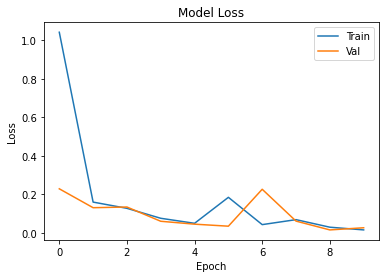

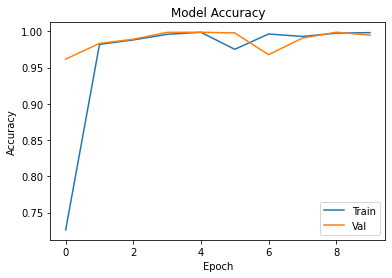

In [ ]:
# Plot the training curve
plot_losses(hist)
plot_accuracies(hist)

### Part D) Your Best Classifier (10 points)

Add on your own last layers to the pretrained model and train it on the training data (in the previous parts you could have only one flatten layer and one dense layer to do the classification). You can increase (or decrease) the number of nodes per layer, increase (or decrease) the number of layers, and add dropout if your model is overfitting, change the hyperparameters, change your optimizer, etc. Try to get the validation accuracy higher than what the previous transfer learning model was able to obtain, and try to minimize the amount of overfitting.

Plot the classification accuracy for each epoch. Report the best test accuracy your model was able to achieve.

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 tf.__operators__.getitem_9   (None, 200, 200, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 200, 200, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d_25 (Conv2D)          (None, 2, 2, 64)          294976    
                                                                 
 flatten_20 (Flatten)        (None, 256)               0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


650/650 [==============================] - 112s 170ms/step - loss: 0.5152 - accuracy: 0.8849 - val_loss: 0.0467 - val_accuracy: 0.9917
Epoch 2/10
650/650 [==============================] - 116s 178ms/step - loss: 0.0209 - accuracy: 0.9987 - val_loss: 0.0189 - val_accuracy: 0.9979
Epoch 3/10
650/650 [==============================] - 116s 179ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0120 - val_accuracy: 0.9988
Epoch 4/10
650/650 [==============================] - 117s 180ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9992
Epoch 5/10
650/650 [==============================] - 117s 179ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0073 - val_accuracy: 0.9992
Epoch 6/10
650/650 [==============================] - 117s 180ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 7/10
650/650 [==============================] - 117s 179ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0054 - val_accura

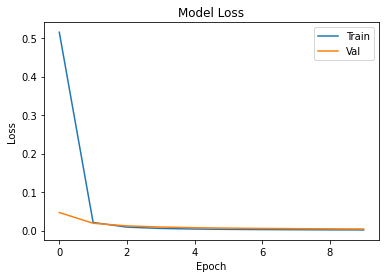

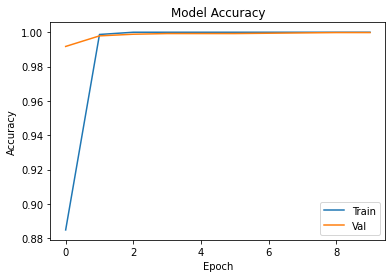

Epoch 1/3
146/650 [=====>........................] - ETA: 3:18 - loss: 0.0328 - accuracy: 0.9902

KeyboardInterrupt: ignored

In [ ]:
base_model.trainable = False

# encoder_input = keras.Input(shape=(200, 200, 3))
# x = tf.keras.applications.vgg16.preprocess_input(encoder_input)
# x = base_model(x, training=False)
# x = layers.Flatten()(x)
# x = layers.Dense(52, activation = 'relu')(x)
# x = layers.Dense(26, activation = 'softmax')(x)
# encoder_output = (x)


encoder_input = keras.Input(shape=(200, 200, 3))
x = tf.keras.applications.vgg16.preprocess_input(encoder_input)
x = base_model(x, training=False)
x = layers.Conv2D(64, 3, activation="relu", strides=2)(x)
x = layers.Flatten()(x)
x = layers.Dense(52, activation = 'relu')(x)
x = layers.Dense(26, activation = 'softmax')(x)
encoder_output = (x)


# And now put this all together to create our new model.
model1 = Model(encoder_input, outputs = encoder_output) 
model1.summary()

# Compile the model
model1.compile(
  optimizer=Adagrad(lr = 0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

hist = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

# Plot the training curve
plot_losses(hist)
plot_accuracies(hist)

# Here I unfreeze the base model and train for another few epochs to try and lightly optimize the 
# base model for my training set, this is a recommendation I found on the keras
# transfer learning page.

base_model.trainable = True

model1.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Train the model
hist = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

# Plot the training curve
plot_losses(hist)
plot_accuracies(hist)

The transfer learning model above was already very accurate, with a best validation accuracy of 0.9946 after 10 epochs. To try and improve this further, I applied a similar technique as what worked well during question 2: changing the optimizer to adagrad and not decreasing the number of parameters being fed into the dense layer by too much. I also added one more convolution layer, with the successful kernel size of 64 and stride of 2 which not only gave me a better validation score, up from 0.9994 to 0.9998, but also decreased the number of trainable parameters, simplifying the model somewhat.

In addition to training my model once without allowing changes to the base layer, I also employed a stragegy I found which trains the entire model for just a few epochs after training only the added layers to attempt to tune the base model slightly for the training set.

Ultimatly this best model I was able to create had a best validation accuracy of 0.9998.